<a href="https://colab.research.google.com/github/jheagbayani/tua_isy503_a3_2025t1/blob/main/ISY503_Group_2_Assessment_3_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISY503 Intelligent Systems - Assessment 3
Group 2:
- Jay-ar Anacleto Agbayani | A00120503
- Archkymuel Ilao Bautista | 00116734
- Nguyen Bui | A00128444
- Hoang Tuan Ngo | A00094718

## 0. Configuration Flags

Set flags here to control notebook behavior, like loading a pre-trained model.

In [ ]:
from importlib import reload

In [ ]:
%%writefile configs.py

# Set to True to skip data loading, preprocessing, tuning, and training,
# and instead load a previously saved model and tokenizer.
# Ensure 'final_best_sentiment_model.h5', 'tokenizer.pkl',
# and 'model_params.json' exist in the root directory.
LOAD_PRETRAINED_MODEL = True

# Preprocessing flags (used if LOAD_PRETRAINED_MODEL is False)
# These MUST match the settings used when the pre-trained model was saved if loading.
APPLY_SPELLING_CORRECTION = True # Set based on whether sym_spell will be available/used
HANDLE_NEGATION_TOKENS = True    # Combine 'not', 'good' -> 'not_good' etc.
REMOVE_STOPWORDS = True         # Remove stopwords (negations are kept by default)
APPLY_LEMMATIZATION = True      # Lemmatize words

# Paths for saving/loading model components
SAVED_MODEL_PATH = 'final_best_sentiment_model--TRUE_TRUE.h5'
SAVED_TOKENIZER_PATH = 'tokenizer--TRUE_TRUE.pkl'
SAVED_PARAMS_PATH = 'model_params--TRUE_TRUE.json' # For max_length and vocab_size

PROJECT_NAME = 'sentiment_tuning--TRUE_TRUE'

Overwriting configs.py


## 1. Setup and Data Acquisition

This section imports necessary libraries, installs required packages, downloads the dataset and supporting files (like spelling dictionary), and extracts the data.

In [ ]:
!pip install contractions -q
!pip install keras_tuner -q
!npm install localtunnel -q
!pip install matplotlib -q
!pip install nltk -q
!pip install numpy -q
!pip install pandas -q
!pip install scikit-learn -q
!pip install seaborn -q
!pip install streamlit -q
!pip install symspellpy -q
!pip install tensorflow -q
!pip install wget -q


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
⠙⠹⠸⠼
up to date, audited 23 packages in 519ms
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼
2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠼
[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1

In [ ]:
%%writefile app_imports.py

from configs import *

import contractions
import json # For saving/loading max_length and vocab_size
import os
import pickle # For saving/loading tokenizer
import re
import streamlit as st
import time # To measure preprocessing time

from symspellpy import SymSpell, Verbosity
from importlib.resources import files

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# NLTK for text processing (tokenization, optional stopwords/lemmatization)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Download necessary NLTK data
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("NLTK data downloaded.")

Overwriting app_imports.py


In [ ]:
import app_imports
reload(app_imports)
from app_imports import *

# Core libraries
import tarfile
import random
import numpy as np
import pandas as pd
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
import wget

# TensorFlow/Keras common imports
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential # Needed if building model

# Scikit-learn common imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Configure plot style
plt.style.use('ggplot')
# Ensure plots are displayed inline in environments like Jupyter
%matplotlib inline

NLTK data downloaded.
NLTK data downloaded.


### 1.1 Download and Prepare Data/Dictionary Files

In [ ]:
%%writefile sympsell_init.py

from app_imports import *

def init_sympspell(spell_correct):
    sym_spell = None # Initialize sym_spell to None

    # --- Set SymSpell Dictionary ---
    dictionary_path = files("symspellpy") / "frequency_dictionary_en_82_765.txt"
    if not os.path.exists(dictionary_path):
        print("Cannot find SymSpell dictionary. Disabling spelling correction.")
    else:
        print(f"\nSymSpell dictionary already exists at {dictionary_path}")

    # --- Initialize SymSpell ---
    if spell_correct and os.path.exists(dictionary_path):
        print("\nInitializing SymSpell...")
        start_time = time.time()
        try:
            sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
            # Load dictionary
            if not sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1):
                print("SymSpell dictionary loading failed.")
                sym_spell = None # Reset if failed
                spell_correct = False # Disable if loading fails
            else:
                print(f"SymSpell initialized successfully in {time.time() - start_time:.2f} seconds.")
        except Exception as e:
            print(f"Error initializing SymSpell: {e}")
            sym_spell = None
            spell_correct = False
    elif spell_correct:
        print("\nSymSpell dictionary file not found. Spelling correction will be skipped.")
        spell_correct = False # Ensure it's disabled

    return sym_spell

Overwriting sympsell_init.py


In [ ]:
import sympsell_init
reload(sympsell_init)
from sympsell_init import *

sym_spell = init_sympspell(APPLY_SPELLING_CORRECTION)


SymSpell dictionary already exists at /Users/jayagbayani/.pyenv/versions/jupyter_env/lib/python3.12/site-packages/symspellpy/frequency_dictionary_en_82_765.txt

Initializing SymSpell...
SymSpell initialized successfully in 1.27 seconds.


In [ ]:
if not LOAD_PRETRAINED_MODEL:
    # --- Dataset Download and Extraction ---
    data_dir = 'data'
    extracted_dir = os.path.join(data_dir, "extracted")
    sorted_data_dir = os.path.join(extracted_dir, "sorted_data_acl")

    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(extracted_dir, exist_ok=True)

    # Download the Multi-Domain Sentiment Dataset
    print("Downloading Multi-Domain Sentiment Dataset...")
    sentiment_url = "https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz"
    sentiment_file_path = os.path.join(data_dir, "domain_sentiment_data.tar.gz")

    if not os.path.exists(sentiment_file_path):
        try:
            wget.download(sentiment_url, sentiment_file_path)
            print(f"\nDownloaded dataset to {sentiment_file_path}")
        except Exception as e:
            print(f"Error downloading dataset: {e}")
    else:
        print(f"Dataset file already exists at {sentiment_file_path}")

    # Extract the downloaded tar.gz file
    if not os.path.exists(sorted_data_dir) and os.path.exists(sentiment_file_path):
        print("\nExtracting the Multi-Domain Sentiment Dataset...")
        try:
            with tarfile.open(sentiment_file_path, 'r:gz') as tar:
                tar.extractall(path=extracted_dir)
                print(f"Extracted contents to {extracted_dir}")
                # Check if the expected directory exists after extraction
                if not os.path.exists(sorted_data_dir):
                    print(f"Warning: Expected directory '{sorted_data_dir}' not found after extraction.")

        except tarfile.ReadError as e:
            print(f"Error reading tar file: {e}. It might be corrupted or incomplete.")
        except Exception as e:
            print(f"An error occurred during extraction: {e}")
    elif os.path.exists(sorted_data_dir):
        print(f"Data appears to be already extracted in {sorted_data_dir}")
    else:
        print("Dataset archive not found. Cannot extract.")

    # List available domains from extracted data
    if os.path.exists(sorted_data_dir):
        domains = [d for d in os.listdir(sorted_data_dir) if os.path.isdir(os.path.join(sorted_data_dir, d))]
        print(f"\nFound domains: {domains}")
    else:
        print(f"\nError: Data directory '{sorted_data_dir}' not found. Cannot proceed.")
        domains = [] # Set domains to empty list to prevent errors later

Dataset file already exists at data/domain_sentiment_data.tar.gz
Data appears to be already extracted in data/extracted/sorted_data_acl

Found domains: ['electronics', 'books', 'dvd', 'kitchen_&_housewares']


## 2. Data Loading and Preprocessing

This section focuses on loading the review text, cleaning it, and preparing it for the model.

### 2.1 Extract Review Text

In [ ]:
def extract_review_text_from_file(file_path):
    """
    Extracts text content between <review_text> tags from a file.
    """
    reviews = []
    if not os.path.exists(file_path):
        print(f"Warning: File not found - {file_path}") # Reduce verbosity
        return reviews
    try:
        with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
            content = f.read()
            found_texts = re.findall(r'<review_text>(.*?)</review_text>', content, re.DOTALL)
            reviews = [text.strip() for text in found_texts if text.strip()]
    except Exception as e:
        print(f"Error reading or parsing file {file_path}: {e}")
    return reviews

### 2.2 Load Data from All Domains

In [ ]:
if not LOAD_PRETRAINED_MODEL:
    all_texts = []
    all_labels = []
    all_domains = []

    print("Loading reviews from all domains...")

    if not domains:
        print("Error: No domains found. Cannot load data.")
    else:
        for domain in domains:
            domain_path = os.path.join(sorted_data_dir, domain)
            print(f"Processing domain: {domain}")

            # Process positive reviews
            pos_file = os.path.join(domain_path, "positive.review")
            pos_texts = extract_review_text_from_file(pos_file)
            all_texts.extend(pos_texts)
            all_labels.extend([1] * len(pos_texts)) # 1 for positive
            all_domains.extend([domain] * len(pos_texts))
            print(f"  Loaded {len(pos_texts)} positive reviews.")

            # Process negative reviews
            neg_file = os.path.join(domain_path, "negative.review")
            neg_texts = extract_review_text_from_file(neg_file)
            all_texts.extend(neg_texts)
            all_labels.extend([0] * len(neg_texts)) # 0 for negative
            all_domains.extend([domain] * len(neg_texts))
            print(f"  Loaded {len(neg_texts)} negative reviews.")

    print(f"\nTotal reviews loaded: {len(all_texts)}")
    print(f"Total labels loaded: {len(all_labels)}")
    if all_texts:
        print(f"Positive reviews: {sum(all_labels)}")
        print(f"Negative reviews: {len(all_labels) - sum(all_labels)}")

Loading reviews from all domains...
Processing domain: electronics
  Loaded 1000 positive reviews.
  Loaded 1000 negative reviews.
Processing domain: books
  Loaded 1000 positive reviews.
  Loaded 1000 negative reviews.
Processing domain: dvd
  Loaded 1000 positive reviews.
  Loaded 1000 negative reviews.
Processing domain: kitchen_&_housewares
  Loaded 1000 positive reviews.
  Loaded 1000 negative reviews.

Total reviews loaded: 8000
Total labels loaded: 8000
Positive reviews: 4000
Negative reviews: 4000


### 2.3 Create DataFrame and Initial Shuffle

In [ ]:
if not LOAD_PRETRAINED_MODEL:
    if not all_texts:
        print("Error: No review texts were loaded. Cannot create DataFrame.")
        reviews_df = pd.DataFrame(columns=['text', 'sentiment', 'domain'])
    else:
        reviews_df = pd.DataFrame({
            'text': all_texts,
            'sentiment': all_labels,
            'domain': all_domains
        })
        # Shuffle the DataFrame
        reviews_df = reviews_df.sample(frac=1, random_state=42).reset_index(drop=True)
        print("\nDataFrame created and shuffled.")
        print(reviews_df.head())
        print(f"\nShape of DataFrame: {reviews_df.shape}")


DataFrame created and shuffled.
                                                text  sentiment       domain
0  Simply Awesome! I keep having to stop the tape...          1        books
1  This volume contains a lot of valuable informa...          1        books
2  Do not be deceived by the photo this thing is ...          0  electronics
3  This book could have been written in 200 pages...          0        books
4  Peirce really suprised me in this movie.  He w...          1          dvd

Shape of DataFrame: (8000, 3)


### 2.4 Text Cleaning and Preprocessing Pipeline

In [ ]:
%%writefile preprocess.py

from sympsell_init import *

# --- Text Cleaning and Preprocessing Functions ---
def expand_contractions(text):
    """Expand contractions in the text."""
    return contractions.fix(text)

def clean_text(text):
    """Basic cleaning: lowercase, punctuation removal (keeping !?), whitespace."""
    if not isinstance(text, str): return "" # Return empty string for non-string input
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s!?]', ' ', text) # Keep letters, numbers, space, !, ?
    text = re.sub(r'\s+([?.!,"])', r'\1', text) # Fix spacing around punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text

def symspell_correct(text, sym_spell_instance):
    """Corrects spelling using a provided SymSpell instance."""
    if not sym_spell_instance or not isinstance(text, str) or not text.strip(): return text
    suggestions = sym_spell_instance.lookup_compound(text, max_edit_distance=2, transfer_casing=True)
    return suggestions[0].term if suggestions else text

def handle_negations(text):
    """Combine common negation words with the following word."""
    negation_words = {"not", "no", "never", "none", "nobody", "nothing", "neither", "nor", "nowhere",
                      "hardly", "scarcely", "barely", "don't", "doesn't", "didn't", "shouldn't",
                      "couldn't", "won't", "wouldn't", "isn't", "aren't", "wasn't", "weren't",
                      "hasn't", "haven't", "hadn't", "ain't"}
    tokens = word_tokenize(text)
    processed_tokens = []
    skip_next = False
    for i, token in enumerate(tokens):
        if skip_next: skip_next = False; continue
        if token in negation_words and i + 1 < len(tokens):
            processed_tokens.append(f"{token}_{tokens[i + 1]}")
            skip_next = True
        else: processed_tokens.append(token)
    return ' '.join(processed_tokens)

def remove_stopwords_custom(text):
    """Removes common English stopwords, excluding common negation words."""
    stop_words = set(stopwords.words('english'))
    negation_words = {"not", "no", "never", "none", "nobody", "nothing", "neither", "nor", "nowhere",
                      "hardly", "scarcely", "barely", "don't", "doesn't", "didn't", "shouldn't",
                      "couldn't", "won't", "wouldn't", "isn't", "aren't", "wasn't", "weren't",
                      "hasn't", "haven't", "hadn't", "ain't"}
    stop_words -= negation_words
    try: word_tokens = word_tokenize(text)
    except Exception: return text
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

def lemmatize_text(text):
    """Lemmatizes text."""
    lemmatizer = WordNetLemmatizer()
    try: word_tokens = word_tokenize(text)
    except Exception: return text
    lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
    return ' '.join(lemmatized_text)

# --- Master Preprocessing Function ---
def preprocess_text_pipeline(text, sym_spell_instance, use_spelling, use_negation_handling, use_stopwords, use_lemmatization):
    """Applies the selected preprocessing steps in a defined order."""
    text = expand_contractions(text)
    text = clean_text(text)
    if use_spelling and sym_spell_instance: text = symspell_correct(text, sym_spell_instance)
    if use_stopwords: text = remove_stopwords_custom(text)
    if use_negation_handling: text = handle_negations(text)
    if use_lemmatization: text = lemmatize_text(text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

Overwriting preprocess.py


In [ ]:
import preprocess
reload(preprocess)
from preprocess import *

# --- Apply Preprocessing to DataFrame (only if not loading) ---
if not LOAD_PRETRAINED_MODEL:
    if 'text' in reviews_df.columns:
        print("\nApplying text preprocessing pipeline...")
        print(f"Settings: Spelling={APPLY_SPELLING_CORRECTION}, Negation Handling={HANDLE_NEGATION_TOKENS}, Stopwords={REMOVE_STOPWORDS}, Lemmatization={APPLY_LEMMATIZATION}")
        start_time = time.time()
        reviews_df['processed_text'] = reviews_df['text'].astype(str).apply(
            lambda x: preprocess_text_pipeline(
                x, sym_spell, APPLY_SPELLING_CORRECTION, HANDLE_NEGATION_TOKENS, REMOVE_STOPWORDS, APPLY_LEMMATIZATION
            )
        )
        end_time = time.time()
        print(f"Preprocessing finished in {end_time - start_time:.2f} seconds.")
        print("\nSample of original vs processed text:")
        print(reviews_df[['text', 'processed_text']].head())
    else:
        print("Error: 'text' column not found in DataFrame. Skipping preprocessing.")


Applying text preprocessing pipeline...
Settings: Spelling=True, Negation Handling=True, Stopwords=True, Lemmatization=True
Preprocessing finished in 92.92 seconds.

Sample of original vs processed text:
                                                text  \
0  Simply Awesome! I keep having to stop the tape...   
1  This volume contains a lot of valuable informa...   
2  Do not be deceived by the photo this thing is ...   
3  This book could have been written in 200 pages...   
4  Peirce really suprised me in this movie.  He w...   

                                      processed_text  
0                 simply awesome keep stop tape sink  
1  volume contains lot valuable information work ...  
2  not_deceived photo thing tiny looking small lo...  
3  book could written page instead james frey not...  
4  peirce really surprised movie always pretty mo...  


### 2.5 Outlier Removal


Original number of reviews: 8000
Removed 21 reviews with < 5 words.
Number of reviews remaining: 7979


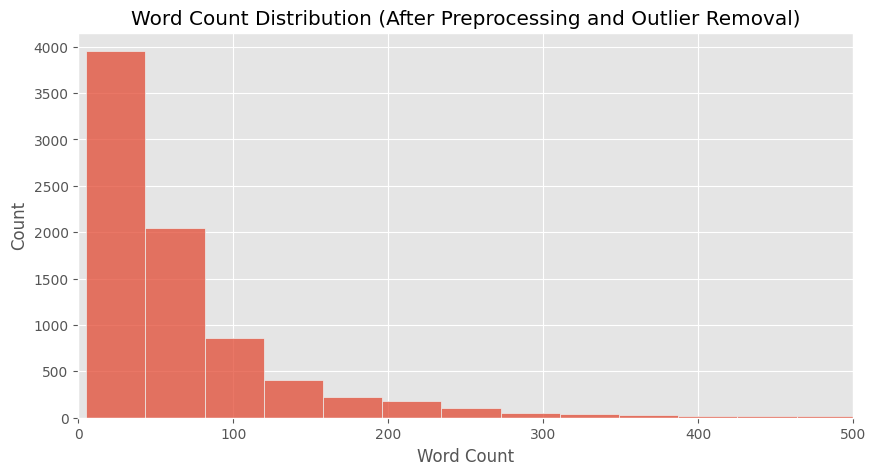

In [ ]:
if not LOAD_PRETRAINED_MODEL:
    if 'processed_text' in reviews_df.columns:
        reviews_df['word_count'] = reviews_df['processed_text'].apply(lambda x: len(x.split()))
        min_words = 5 # Define minimum word count

        print(f"\nOriginal number of reviews: {len(reviews_df)}")
        initial_count = len(reviews_df)
        reviews_df = reviews_df[reviews_df['word_count'] >= min_words].copy()
        removed_count = initial_count - len(reviews_df)
        print(f"Removed {removed_count} reviews with < {min_words} words.")
        print(f"Number of reviews remaining: {len(reviews_df)}")

        # Display word count distribution
        plt.figure(figsize=(10, 5))
        sns.histplot(reviews_df['word_count'], bins=50)
        plt.title('Word Count Distribution (After Preprocessing and Outlier Removal)')
        plt.xlabel('Word Count');
        plt.xlim(0, 500);
        plt.show()
    else:
        print("Skipping outlier removal as 'processed_text' column is missing.")

### 2.6 Tokenization and Padding

In [ ]:
if not LOAD_PRETRAINED_MODEL:
    if 'processed_text' in reviews_df.columns and not reviews_df.empty:
        # Parameters for tokenization and padding
        max_words = 10000  # Max number of words to keep in vocabulary
        oov_token = "<OOV>" # Token for words not in vocabulary

        # Initialize and fit tokenizer
        tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
        tokenizer.fit_on_texts(reviews_df['processed_text'])
        vocab_size = len(tokenizer.word_index) + 1
        actual_vocab_size = min(vocab_size, max_words)
        print(f"\nEffective vocabulary size for Embedding layer: {actual_vocab_size}")

        # Convert text to sequences
        sequences = tokenizer.texts_to_sequences(reviews_df['processed_text'])
        seq_lengths = [len(s) for s in sequences]
        if not seq_lengths:
            print("Warning: No sequences generated.")
            max_length = 100 # Default max_length
        else:
            max_length = max(1, int(np.percentile(seq_lengths, 95)))
        print(f"Using max_length = {max_length} for padding.")

        # Pad sequences
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
        print(f"Shape of padded sequences: {padded_sequences.shape}")

        # --- Save Tokenizer and Params ---
        print(f"\nSaving tokenizer to {SAVED_TOKENIZER_PATH}")
        with open(SAVED_TOKENIZER_PATH, 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

        params_to_save = {'max_length': max_length, 'actual_vocab_size': actual_vocab_size}
        print(f"Saving model params (max_length, vocab_size) to {SAVED_PARAMS_PATH}")
        with open(SAVED_PARAMS_PATH, 'w') as f:
            json.dump(params_to_save, f)
        # -------------------------------

    else:
        print("Error: Cannot perform tokenization. 'processed_text' column missing or DataFrame is empty.")
        padded_sequences = np.array([])
        labels_array = np.array([])
        actual_vocab_size = 1 # Default value
        max_length = 1 # Default value
        tokenizer = None


Effective vocabulary size for Embedding layer: 10000
Using max_length = 220 for padding.
Shape of padded sequences: (7979, 220)

Saving tokenizer to tokenizer--TRUE_TRUE.pkl
Saving model params (max_length, vocab_size) to model_params--TRUE_TRUE.json


### 2.7 Prepare Labels and Split Data

In [ ]:
if not LOAD_PRETRAINED_MODEL:
    if padded_sequences.size > 0:
        labels_array = np.array(reviews_df['sentiment'])

        # Split into Train/Validation (85%) and Test (15%)
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            padded_sequences,
            labels_array,
            test_size=0.15,
            random_state=42,
            stratify=labels_array
        )

        # Split Train/Validation into Train and Validation
        val_split_ratio = X_test.shape[0] / X_train_val.shape[0] if X_train_val.shape[0] > 0 else 0.15
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val,
            y_train_val,
            test_size=val_split_ratio,
            random_state=42,
            stratify=y_train_val
        )

        print("\nData Splitting:")
        print(f"Training set shape:   X={X_train.shape}, y={y_train.shape}")
        print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
        print(f"Test set shape:       X={X_test.shape}, y={y_test.shape}")

        # Verify class distribution in each set
        print("\nClass Distribution:")
        print(f"Train: Positive={sum(y_train)}, Negative={len(y_train)-sum(y_train)}")
        print(f"Valid: Positive={sum(y_val)}, Negative={len(y_val)-sum(y_val)}")
        print(f"Test:  Positive={sum(y_test)}, Negative={len(y_test)-sum(y_test)}")
    else:
        print("Error: Padded sequences are empty. Cannot split data.")
        X_train, X_val, X_test = np.array([]), np.array([]), np.array([])
        y_train, y_val, y_test = np.array([]), np.array([]), np.array([])
        X_train_val, y_train_val = np.array([]), np.array([])


Data Splitting:
Training set shape:   X=(5585, 220), y=(5585,)
Validation set shape: X=(1197, 220), y=(1197,)
Test set shape:       X=(1197, 220), y=(1197,)

Class Distribution:
Train: Positive=2793, Negative=2792
Valid: Positive=598, Negative=599
Test:  Positive=598, Negative=599


## 3. Model Development, Tuning, and Training

### 3.1 Define Model Building Function for Keras Tuner

In [ ]:
def build_model(hp):
    """Builds a Keras model with tunable hyperparameters."""
    # Define hyperparameter search space
    hp_embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=128, step=32)
    hp_lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    hp_spatial_dropout = hp.Float('spatial_dropout', min_value=0.1, max_value=0.5, step=0.1)
    hp_lstm_dropout = hp.Float('lstm_dropout', min_value=0.1, max_value=0.5, step=0.1)
    hp_recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    model = Sequential([
        # 1. Embedding Layer
        Embedding(input_dim=actual_vocab_size,
                  output_dim=hp_embedding_dim,
                  input_length=max_length,
                  mask_zero=True),
        # 2. Spatial Dropout
        SpatialDropout1D(hp_spatial_dropout),
        # 3. Bidirectional LSTM
        Bidirectional(LSTM(hp_lstm_units,
                           dropout=hp_lstm_dropout,
                           recurrent_dropout=hp_recurrent_dropout)),
        # 4. Dense Layer
        # Dense(32, activation='relu'),
        # Dropout(dropout_rate),
        # 5. Output Layer
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # model.summary()
    return model

### 3.2 Configure and Run Keras Tuner Search

In [ ]:
tuner = None
best_hps = None
best_model_from_tuner = None # Store the direct output from tuner

if not LOAD_PRETRAINED_MODEL:
    if 'X_train' in locals() and X_train.size > 0:
        print("\nConfiguring Keras Tuner...")
        tuner = kt.RandomSearch(
            build_model,
            objective='val_accuracy',
            max_trials=10, # Number of models to test
            executions_per_trial=1,
            directory='keras_tuner_dir',
            project_name=PROJECT_NAME,
            overwrite=True
        )
        tuner_early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=1
        )

        print("Starting hyperparameter search...")
        start_time = time.time()
        tuner.search(
            X_train,
            y_train,
            epochs=10,
            validation_data=(X_val, y_val),
            callbacks=[tuner_early_stopping],
            verbose=1
        )
        end_time = time.time()
        print(f"Hyperparameter search finished in {end_time - start_time:.2f} seconds.")

        # Get best HPs and model
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        best_model_from_tuner = tuner.get_best_models(num_models=1)[0] # Get the best model instance

        print("\nOptimal Hyperparameters Found:")
        # Print hyperparameters
        for hp_name in best_hps.values:
             print(f"  {hp_name}: {best_hps.get(hp_name)}")

        print("\nTuner Search Summary:")
        tuner.results_summary(num_trials=5) # Show top 5 trials

    else:
        print("Error: Training data not available. Skipping hyperparameter tuning.")

Trial 10 Complete [00h 05m 12s]
val_accuracy: 0.8020049929618835

Best val_accuracy So Far: 0.8195488452911377
Total elapsed time: 00h 29m 22s
Hyperparameter search finished in 1762.06 seconds.

Optimal Hyperparameters Found:
  embedding_dim: 128
  lstm_units: 96
  spatial_dropout: 0.2
  lstm_dropout: 0.5
  recurrent_dropout: 0.1
  learning_rate: 0.0005

Tuner Search Summary:
Results summary
Results in keras_tuner_dir/sentiment_tuning--TRUE_TRUE
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
embedding_dim: 128
lstm_units: 96
spatial_dropout: 0.2
lstm_dropout: 0.5
recurrent_dropout: 0.1
learning_rate: 0.0005
Score: 0.8195488452911377

Trial 04 summary
Hyperparameters:
embedding_dim: 64
lstm_units: 96
spatial_dropout: 0.2
lstm_dropout: 0.1
recurrent_dropout: 0.2
learning_rate: 0.001
Score: 0.8170425891876221

Trial 02 summary
Hyperparameters:
embedding_dim: 96
lstm_units: 32
spatial_dropout: 0.1
lstm_dropout: 0.5
recurrent_dropout

/Users/jayagbayani/.pyenv/versions/jupyter_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 3.3 Re-train the Best Model on Full Training Data (`X_train_val`)


Re-training the best model on the combined training and validation data...
Re-training for up to 15 epochs...
Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5705 - loss: 0.6744
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.8150 - loss: 0.4230
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.8913 - loss: 0.2820
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.9309 - loss: 0.1977
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.9495 - loss: 0.1466
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.9572 - loss: 0.1203
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.9693 - loss: 0.0932
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.9757 - loss: 0.0674
Epoch 9/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9750 - loss: 0.0739
Epoch 10/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9798 - loss: 0.056

Re-training finished in 228.20 seconds.
Saving re-trained model to final_best_sentiment_model--TRUE_TRUE.h5


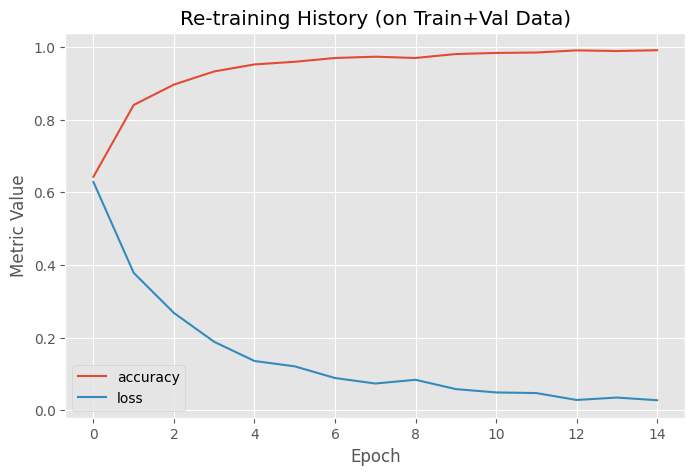

In [ ]:
final_model = None # Initialize final_model

if not LOAD_PRETRAINED_MODEL:
    if best_hps is not None and 'X_train_val' in locals() and X_train_val.size > 0:
        print("\nRe-training the best model on the combined training and validation data...")
        # Build a new model instance with the best hyperparameters
        final_model = build_model(best_hps)

        retrain_epochs = 15 # Allow potentially more epochs on combined data
        retrain_early_stopping = EarlyStopping(
            monitor='loss', # Monitor training loss as there's no separate val_loss
            patience=3,
            verbose=1,
            restore_best_weights=True # Restore based on training loss minimum
        )

        print(f"Re-training for up to {retrain_epochs} epochs...")
        start_time = time.time()
        history_final = final_model.fit(
            X_train_val, y_train_val, # Use combined data
            epochs=retrain_epochs,
            batch_size=64,
            callbacks=[retrain_early_stopping],
            verbose=1
        )
        end_time = time.time()
        print(f"Re-training finished in {end_time - start_time:.2f} seconds.")

        # Save the re-trained model
        print(f"Saving re-trained model to {SAVED_MODEL_PATH}")
        final_model.save(SAVED_MODEL_PATH)

        # Plot re-training history (only shows training loss/accuracy)
        if history_final and history_final.history:
             pd.DataFrame(history_final.history).plot(figsize=(8, 5))
             plt.title("Re-training History (on Train+Val Data)")
             plt.xlabel("Epoch")
             plt.ylabel("Metric Value")
             plt.grid(True)
             plt.show()

    elif best_model_from_tuner is not None:
         print("\nWarning: Re-training skipped (no best HPs or combined data?). Using best model directly from tuner search.")
         final_model = best_model_from_tuner # Fallback to model from tuner
         # Save this model if it wasn't saved already
         print(f"Saving best model from tuner search to {SAVED_MODEL_PATH}")
         final_model.save(SAVED_MODEL_PATH)
    else:
        print("Error: Cannot re-train model (tuning might have failed or data is missing).")

## 4. Load Model and Evaluate (or Load Pre-trained)

Load the final trained model (either re-trained or loaded from file) and evaluate its performance on the unseen test set.

In [ ]:
# --- Load Model Section ---
if LOAD_PRETRAINED_MODEL:
    print(f"\nLoading pre-trained model from {SAVED_MODEL_PATH}...")
    if os.path.exists(SAVED_MODEL_PATH) and os.path.exists(SAVED_TOKENIZER_PATH) and os.path.exists(SAVED_PARAMS_PATH):
        try:
            final_model = load_model(SAVED_MODEL_PATH)
            print("Model loaded successfully.")
            with open(SAVED_TOKENIZER_PATH, 'rb') as handle:
                tokenizer = pickle.load(handle)
            print("Tokenizer loaded successfully.")
            with open(SAVED_PARAMS_PATH, 'r') as f:
                loaded_params = json.load(f)
            max_length = loaded_params['max_length']
            actual_vocab_size = loaded_params['actual_vocab_size']
            print(f"Model parameters loaded (max_length={max_length}, vocab_size={actual_vocab_size}).")

            # Assume X_test, y_test might exist from a previous partial run
            # Or handle error if they don't exist.
            if 'X_test' not in locals() or 'y_test' not in locals():
                 print("Warning: Loading pre-trained model, but test data (X_test, y_test) not found in current session.")
                 print("Re-run the data loading/splitting cells (with LOAD_PRETRAINED_MODEL=False) first, or manually load test data.")
                 # Set test data to empty to prevent evaluation errors
                 X_test, y_test = np.array([]), np.array([])

        except Exception as e:
            print(f"Error loading pre-trained model or components: {e}")
            final_model = None; tokenizer = None; max_length = 1; actual_vocab_size = 1
            X_test, y_test = np.array([]), np.array([])
    else:
        print("Error: One or more required files not found for loading pre-trained model.")
        print(f"Ensure '{SAVED_MODEL_PATH}', '{SAVED_TOKENIZER_PATH}', and '{SAVED_PARAMS_PATH}' exist.")
        final_model = None; tokenizer = None; max_length = 1; actual_vocab_size = 1
        X_test, y_test = np.array([]), np.array([])

elif 'final_model' not in locals() or final_model is None:
    print("Error: No final model available (training might have failed). Skipping evaluation.")
    X_test, y_test = np.array([]), np.array([]) # Ensure test vars are defined


Evaluating the final model on the test set...
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7789 - loss: 1.0505

Test Loss (Final Model): 0.9176
Test Accuracy (Final Model): 0.8020
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Classification Report (Final Model):
              precision    recall  f1-score   support

    Negative       0.81      0.78      0.80       599
    Positive       0.79      0.82      0.81       598

    accuracy                           0.80      1197
   macro avg       0.80      0.80      0.80      1197
weighted avg       0.80      0.80      0.80      1197



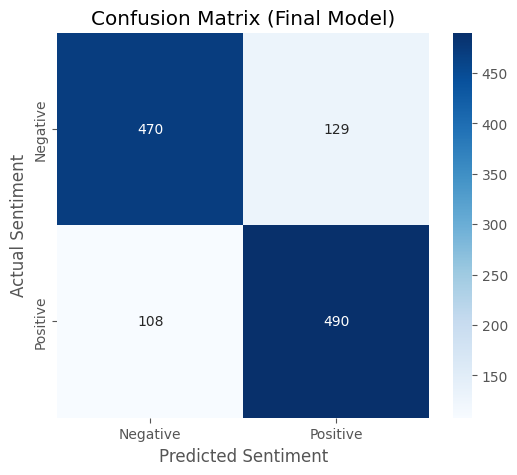

In [ ]:
# --- Evaluation Section ---
test_accuracy = "N/A" # Default value
if 'final_model' in locals() and final_model is not None and 'X_test' in locals() and X_test.size > 0:
    print("\nEvaluating the final model on the test set...")
    test_loss, test_accuracy_val = final_model.evaluate(X_test, y_test, verbose=1)
    test_accuracy = f"{test_accuracy_val:.4f}" # Store as string for report
    print(f"\nTest Loss (Final Model): {test_loss:.4f}")
    print(f"Test Accuracy (Final Model): {test_accuracy_val:.4f}")

    # Generate predictions
    y_pred_prob = final_model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Classification Report
    print("\nClassification Report (Final Model):")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix (Final Model)')
    plt.ylabel('Actual Sentiment')
    plt.xlabel('Predicted Sentiment')
    plt.show()
else:
    print("Skipping evaluation as final model or test data is not available.")

## 5. Model Inference

Use the **final model** (loaded or trained) to predict the sentiment of new text inputs.

In [ ]:
%%writefile predict.py

from preprocess import *

def predict_sentiment(text, model_to_use, tokenizer_to_use, max_len, sym_spell, preprocessing_params):
    """
    Predicts the sentiment of a given text using the trained model.
    Also returns the preprocessed text.

    Args:
        text (str): The input text (review).
        model_to_use: The trained Keras model.
        tokenizer_to_use: The fitted Keras Tokenizer.
        max_len (int): The maximum sequence length used for padding.

    Returns:
        tuple: (sentiment_label, confidence_score, preprocessed_text)
    """
    if not model_to_use or not tokenizer_to_use:
        print("Error: Model or tokenizer not available for prediction.")
        return "Error", 0.0, ""

    # 1. Preprocess the input text using the *same* pipeline settings
    cleaned = preprocess_text_pipeline(
        text,
        # sym_spell_instance=preprocessing_params['sym_spell'],
        sym_spell_instance=sym_spell,
        use_spelling=preprocessing_params['use_spelling'],
        use_negation_handling=preprocessing_params['use_negation_handling'],
        use_stopwords=preprocessing_params['use_stopwords'],
        use_lemmatization=preprocessing_params['use_lemmatization']
    )

    # 2. Convert text to sequence
    sequence = tokenizer_to_use.texts_to_sequences([cleaned])

    # 3. Pad the sequence
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 4. Make prediction
    prediction = model_to_use.predict(padded, verbose=0)[0][0]

    # 5. Determine label and confidence
    if prediction >= 0.5:
        sentiment = "POSITIVE"
        confidence = prediction
    else:
        sentiment = "NEGATIVE"
        confidence = 1 - prediction

    return sentiment, confidence, cleaned # Return cleaned text as well

Overwriting predict.py


### 5.1 Test Inference Function

Test the `predict_sentiment` function with example sentences using the final model.

In [ ]:
import predict
reload(predict)
from predict import *

# Check if the final model and tokenizer are available
if 'final_model' in locals() and final_model is not None and 'tokenizer' in locals() and tokenizer is not None:
    print("\nTesting inference on new reviews using the final model...")
    test_reviews = [
        # Positive Examples
        "This product is absolutely fantastic! Best purchase I've made all year.",
        "I was very happy with the quality and the fast delivery. Highly recommended!",
        # Negative Examples
        "Terrible quality, broke after just one use. Complete waste of money.",
        "I am extremely disappointed with this item and the customer service was unhelpful.",
        # Examples with Negation
        "This is not bad at all, quite good actually.",
        "I was not disappointed with this purchase.",
        "This isn't the best product, but it's certainly not the worst.",
        "Never had such a terrible experience before.",
        # Examples with potential spelling errors (if correction enabled)
        "The qaulity is amazing for the price point.",
        "Very dissapointed with the item recived."
    ]

    print("\nApplying text preprocessing pipeline...")
    print(f"Settings: Spelling={APPLY_SPELLING_CORRECTION}, Negation Handling={HANDLE_NEGATION_TOKENS}, Stopwords={REMOVE_STOPWORDS}, Lemmatization={APPLY_LEMMATIZATION}\n")

    preprocessing_params = {
        # 'sym_spell': sym_spell,
        'use_spelling': APPLY_SPELLING_CORRECTION,
        'use_negation_handling': HANDLE_NEGATION_TOKENS,
        'use_stopwords': REMOVE_STOPWORDS,
        'use_lemmatization': APPLY_LEMMATIZATION
    }

    for review in test_reviews:
        sentiment, confidence, preprocessed = predict_sentiment(review, final_model, tokenizer, max_length, sym_spell, preprocessing_params)
        print(f"Original: \"{review[:80]}...\"")
        print(f"Preprocessed: \"{preprocessed[:80]}...\"")
        print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.3f})\n")

    print("-" * 30)
    print("Note on Negation Handling Results:")
    print("Observe the predictions for sentences like 'not bad at all' or 'not disappointed'.")
    print("If the model predicts 'Negative' for these, it indicates it hasn't fully learned")
    print("to interpret the combined negation tokens (e.g., 'not_bad') correctly as positive.")
    print("This is a common challenge and may require more advanced techniques or model architectures.")
    print("-" * 30)

else:
    print("Final model or tokenizer not available. Skipping inference test.")


Testing inference on new reviews using the final model...

Applying text preprocessing pipeline...
Settings: Spelling=True, Negation Handling=True, Stopwords=True, Lemmatization=True

Original: "This product is absolutely fantastic! Best purchase I've made all year...."
Preprocessed: "product absolutely fantastic best purchase made year..."
Predicted Sentiment: POSITIVE (Confidence: 1.000)

Original: "I was very happy with the quality and the fast delivery. Highly recommended!..."
Preprocessed: "happy quality fast delivery highly recommended..."
Predicted Sentiment: POSITIVE (Confidence: 1.000)

Original: "Terrible quality, broke after just one use. Complete waste of money...."
Preprocessed: "terrible quality broke one use complete waste money..."
Predicted Sentiment: NEGATIVE (Confidence: 1.000)

Original: "I am extremely disappointed with this item and the customer service was unhelpfu..."
Preprocessed: "extremely disappointed item customer service unhelpful..."
Predicted Sentiment:

## 6. Conclusion and Ethical Considerations

Summary of the project and discussion of ethical aspects related to sentiment analysis.

### 6.1 Project Summary

This project successfully implemented and optimized a sentiment analysis model for Amazon product reviews using a Bidirectional LSTM network. Key steps included:

1.  **Data Acquisition & Setup:** Downloaded and extracted the dataset, installed necessary libraries (`symspellpy`, `keras-tuner`), and prepared the spelling correction dictionary. Added an option to load a pre-trained model to bypass setup and training.
2.  **Focused Preprocessing:** Loaded data focusing only on `<review_text>`, cleaned the text, handled outliers, and implemented configurable preprocessing steps including SymSpellPy spelling correction, negation handling (token combination), stopword removal (preserving negations), and lemmatization. Saved the tokenizer and key parameters (`max_length`, `vocab_size`) for consistent inference.
3.  **Automated Hyperparameter Tuning:** Utilized Keras Tuner (`RandomSearch`) to systematically explore different combinations of `embedding_dim`, `lstm_units`, dropout rates, and `learning_rate` to find an optimal model configuration.
4.  **Model Re-training:** Re-trained the best model architecture found by the tuner on the combined training and validation dataset (`X_train_val`) for potential performance improvement and saved the final model.
5.  **Evaluation:** Assessed the performance of the final model on a held-out test set using accuracy, classification report, and confusion matrix.
6.  **Inference:** Developed and tested a function to predict the sentiment of new, unseen text inputs using the final optimized model and the corresponding preprocessing pipeline, also returning the preprocessed text.

The Keras Tuner identified optimal hyperparameters, and the final re-trained model achieved a test accuracy of `80.2%`. This demonstrates the effectiveness of automated tuning and re-training. The final performance also depends heavily on the chosen preprocessing steps (spelling correction, negation handling, stopwords, lemmatization). Issues with correctly interpreting negated phrases (e.g., "not bad") were observed, highlighting limitations of the current approach for complex semantic understanding.

### 6.2 Ethical Considerations

It is crucial to consider the ethical implications of sentiment analysis:

* **Bias in Data:** The training data (Amazon reviews) may reflect biases present in the reviewers or the platform (e.g., demographic bias, product category bias, prevalence of extreme opinions). This can lead to the model performing unfairly or inaccurately for certain groups or types of reviews. The original data labeling (positive/negative) itself might have biases that the model learns. Spelling correction (even improved ones like SymSpellPy) might also introduce bias if it performs differently on text written by different demographic groups or corrects culturally specific terms incorrectly.
* **Context and Nuance:** Sentiment analysis models, especially simpler architectures like LSTMs, often struggle with sarcasm, irony, conditional statements, or culturally specific expressions. A simplistic positive/negative classification might misinterpret complex human emotions and opinions. As observed, handling negation effectively remains a challenge.
* **Misinformation and Manipulation:** Sentiment analysis could be misused to automatically suppress negative feedback, artificially inflate product reputations, or manipulate public opinion.
* **Fairness and Transparency:** It's important to be transparent about the model's capabilities and limitations, including the hyperparameters found and the preprocessing steps used. Confidence scores should be provided, and users should understand that the output is a prediction, not a definitive judgment. Ensuring the model treats different viewpoints fairly is an ongoing challenge.
* **Privacy:** Analyzing user-generated content requires adherence to privacy regulations and ethical handling of potentially sensitive information within reviews.

As data science practitioners, we have a responsibility to develop and deploy AI systems like this one ethically, being mindful of potential harms and striving for fairness, transparency, and accountability. Continuous monitoring, evaluation for bias, and refinement are necessary to mitigate risks and improve robustness.

## 7. Web User Interface

In [ ]:
%%writefile app.py

# ----------------------------------
# IMPORTS
# ----------------------------------
from predict import *
import base64
import html

# ----------------------------------
# STREAMLIT PAGE SETUP
# ----------------------------------
st.set_page_config(layout="centered")

# ----------------------------------
# GLOBAL CONSTANTS AND CONFIGURATIONS DEFINED IN THIS SCRIPT
# (Other constants like APPLY_SPELLING_CORRECTION, SAVED_MODEL_PATH etc. are assumed to be imported from predict.py)
# ----------------------------------
MIN_WORDS_FOR_ANALYSIS = 5  # Minimum word count for analysis

# Paths for model, tokenizer, and parameters are set using variables from predict.py
MODEL_PATH = SAVED_MODEL_PATH
TOKENIZER_PATH = SAVED_TOKENIZER_PATH
PARAMS_PATH = SAVED_PARAMS_PATH
LOGO_PATH = "Torrens Logo.jpeg"

# Team member information for display
TEAM_MEMBERS = [
    {"name": "Jay-ar Anacleto Agbayani", "id": "A00120503", "image": "Jay.jpeg"},
    {"name": "Archkymuel Ilao Bautista", "id": "A00116734", "image": "Arki.jpeg"},
    {"name": "Nguyen Bui", "id": "A00128444", "image": "Lux.jpeg"},
    {"name": "Hoang Tuan Ngo", "id": "A00094718", "image": "Tuan.jpeg"},
]

# ----------------------------------
# INITIALIZATION OF EXTERNAL RESOURCES
# ----------------------------------
# Initialize the SymSpell object for spelling correction.
# init_sympspell and APPLY_SPELLING_CORRECTION are from predict.py
sym_spell = init_sympspell(APPLY_SPELLING_CORRECTION)

# ----------------------------------
# HELPER FUNCTIONS
# ----------------------------------
# Encodes an image file to a base64 string for embedding in HTML.
def get_base64_of_img(file_path):
    if not os.path.exists(file_path):
        print(f"Image not found: {file_path}")
        return None
    try:
        with open(file_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode('utf-8')
    except Exception as e:
        print(f"Error encoding image {file_path}: {e}")
        return None

# ----------------------------------
# CUSTOM CSS STYLING
# ----------------------------------
# Apply custom CSS for styling the application components.
st.markdown(
    """
    <style>
        /* Import Poppins Font */
        @import url('https://fonts.googleapis.com/css2?family=Poppins:wght@400;500;600;700&display=swap');
        body, .stApp, h1, h2, h3, h4, h5, h6, p, div, span, label, button, input, textarea, select {
            font-family: 'Poppins', sans-serif;
        }
        .stButton>button, .stDownloadButton>button, .stTextInput input, .stTextArea textarea, .stSelectbox div[data-baseweb="select"] > div {
            font-family: 'Poppins', sans-serif;
        }

        div.block-container { /* Main content container */
            max-width: 960px;
        }

        /* Styling for the sentiment result display box */
        .result-box {
            border: 1px solid #e0e0e0; border-radius: 10px; padding: 15px;
            text-align: center;
            min-height: 150px; /* Ensure consistent height */
            height: 150px;     /* Fixed height */
            display: flex; flex-direction: column;
            justify-content: center; /* Center content vertically */
        }
        .result-box h2 { /* Sentiment label (Positive/Negative) */
            margin-top: 0;
            margin-bottom: 5px;
        }
        .positive-bg { background-color: #d4edda; color: #155724; } /* Background for positive sentiment */
        .negative-bg { background-color: #f8d7da; color: #721c24; } /* Background for negative sentiment */

        /* Styling for the analyze button container and button */
        .analyze-button-container { margin-top: 10px; }
        .analyze-button-container button {
            background-color: #87CEEB; color: black; border: 1px solid #7AC5E4;
            border-radius: 5px; padding: 0.5em 1em;
        }
        .analyze-button-container button:hover { background-color: #7AC5E4; color: black; border: 1px solid #6AB0D0; }
        .analyze-button-container button:active { background-color: #6AB0D0; color: black; border: 1px solid #5A9CBC; }

        /* Styling for individual items in the analysis history */
        .history-item {
            margin-bottom: 5px; padding: 8px; border-radius: 5px; display: flex;
            justify-content: space-between; align-items: center; border: 1px solid #eee;
        }
        .history-text { /* Analyzed text in history */
            flex-grow: 1; margin-right: 10px; overflow: hidden;
            text-overflow: ellipsis; word-break: break-word;
        }
        .history-text-positive { color: #272727; } /* Text color for positive history items */
        .history-text-negative { color: #272727; } /* Text color for negative history items */
        .history-sentiment { /* Sentiment and confidence in history */
            font-weight: bold; color: #272727; white-space: nowrap; flex-shrink: 0;
        }
        .history-positive-bg { background-color: #d4edda; } /* Background for positive history items */
        .history-negative-bg { background-color: #f8d7da; } /* Background for negative history items */

        /* Styling for the scrollable history box */
        .scrollable-history-box {
            height: 300px; overflow-y: auto; border: 1px solid #dee2e6;
            border-radius: 5px; padding: 10px; margin-top: 10px; background-color: #ffffff;
        }

        /* MODIFIED: Team Member Styling - Remove box and background */
        /* General container for a team member's card - note: .team-member-container was added in HTML */
        .team-member-container {
            display: flex; /* Aligns image and details side-by-side */
            align-items: center; /* Vertically aligns items in the center */
            margin-bottom: 10px; /* Space below each member card */
            /* Removed border and background for a cleaner look */
        }
        .team-member-img-placeholder { /* Placeholder if image is missing */
            width: 40px; height: 40px;
            border-radius: 50%; background-color: #ccc;
            display: flex; align-items: center; justify-content: center;
            color: #fff; font-size: 1em;
            flex-shrink: 0; /* Prevents shrinking */
            margin-left: 10px; /* Added margin to separate from text if details are on left */
        }
        .team-member-details { /* Container for name and ID */
            display: flex; flex-direction: column;
            margin-right: 10px; /* Space between details and image (if image is on the right) */
            flex-grow: 1; /* Allows details to take available space */
        }
        .team-member-name { font-weight: bold; font-size: 0.8em; }
        .team-member-id { font-size: 0.7em; color: #555; }
        .team-member-img { /* Actual team member image */
            width: 40px; height: 40px;
            border-radius: 50%; object-fit: cover;
            flex-shrink: 0; /* Prevents shrinking */
        }
        /* End MODIFIED Team Member Styling */

        /* Styling for the application header (logo and course text) */
        .app-header {
            display: flex;
            justify-content: space-between; /* Pushes logo and text to opposite ends */
            align-items: center; /* Vertically aligns items */
            margin-bottom: 20px; /* Space below the header */
        }
        .header-text { /* Text in the header (e.g., course name) */
            text-align: right;
            font-size: 1.1em;
            font-weight: 500;
            color: #333;
        }
    </style>
    """,
    unsafe_allow_html=True,
)

# ----------------------------------
# RESOURCE LOADING FUNCTION (CACHED)
# ----------------------------------
# Loads the sentiment analysis model, tokenizer, and model parameters.
# Uses Streamlit's cache to avoid reloading on every interaction.
@st.cache_resource
def load_resources(model_path, tokenizer_path, params_path):
    try:
        # Check if resource files exist
        if not os.path.exists(model_path):
            st.error(f"Model file not found: {model_path}")
            return None, None, None
        if not os.path.exists(tokenizer_path):
            st.error(f"Tokenizer file not found: {tokenizer_path}")
            return None, None, None
        if not os.path.exists(params_path):
            st.error(f"Parameters file not found: {params_path}")
            return None, None, None

        # Load model parameters (e.g., max_length for padding)
        with open(params_path, 'r') as f:
            loaded_params = json.load(f)
            max_length = loaded_params.get('max_length', 100)

        # Load the tokenizer
        with open(tokenizer_path, 'rb') as handle:
            tokenizer = pickle.load(handle)

        # Load the Keras model
        model = tf.keras.models.load_model(model_path, compile=False)
        return model, tokenizer, max_length
    except Exception as e:
        st.error(f"An error occurred during resource loading: {e}")
        return None, None, None

# ----------------------------------
# SESSION STATE INITIALIZATION & MANAGEMENT
# ----------------------------------
# Initialize session state variables if they don't already exist.
# This helps maintain state across user interactions.

# Load model, tokenizer, and max_length into session state if not already loaded
if 'model' not in st.session_state or st.session_state.model is None:
    model, tokenizer, loaded_max_length = load_resources(MODEL_PATH, TOKENIZER_PATH, PARAMS_PATH)
    if model and tokenizer and loaded_max_length:
        st.session_state.model = model
        st.session_state.tokenizer = tokenizer
        st.session_state.loaded_max_length = loaded_max_length
    else:
        st.session_state.model = None
        st.session_state.tokenizer = None
        st.session_state.loaded_max_length = None
        st.warning("Failed to load necessary model resources. Sentiment analysis may not work.")

# Stores the result (sentiment, confidence) of the latest analysis
if 'latest_analysis_result' not in st.session_state:
    st.session_state.latest_analysis_result = None

# Stores a list of past analyses (text, sentiment, confidence)
if 'analysis_history' not in st.session_state:
    st.session_state.analysis_history = []

# Stores the current text in the input text area
if 'current_text_widget' not in st.session_state:
    st.session_state.current_text_widget = ""

# ----------------------------------
# CORE APPLICATION LOGIC / CALLBACK FUNCTIONS
# ----------------------------------
# Resets the application state, clearing history and current results.
def reset_app():
    st.session_state.analysis_history = []
    st.session_state.latest_analysis_result = None
    st.session_state.current_text_widget = "" # Clears the text input area

# Analyzes the text entered by the user for sentiment.
def analyze_text():
    input_text = st.session_state.current_text_widget.strip()

    if not input_text:
        st.warning("Please enter text to analyze.")
        st.session_state.latest_analysis_result = None
        return

    word_count = len(input_text.split())
    if word_count < MIN_WORDS_FOR_ANALYSIS:
        st.warning(f"Please enter at least {MIN_WORDS_FOR_ANALYSIS} words for analysis. You entered {word_count} word(s).")
        st.session_state.latest_analysis_result = None
        return

    # Define preprocessing parameters to be passed to the prediction function
    # Assumes these constants (APPLY_SPELLING_CORRECTION, etc.) are from predict.py
    preprocessing_params = {
        'use_spelling': APPLY_SPELLING_CORRECTION,
        'use_negation_handling': HANDLE_NEGATION_TOKENS,
        'use_stopwords': REMOVE_STOPWORDS,
        'use_lemmatization': APPLY_LEMMATIZATION
    }

    if st.session_state.model and st.session_state.tokenizer and st.session_state.loaded_max_length:
        # Call the prediction function (from predict.py)
        result_tuple = predict_sentiment(
            input_text,
            st.session_state.model,
            st.session_state.tokenizer,
            st.session_state.loaded_max_length,
            sym_spell, # Pass the initialized SymSpell object
            preprocessing_params
        )

        if result_tuple and result_tuple[0] is not None:
            current_sentiment, current_confidence, current_cleaned_text = result_tuple
            st.session_state.latest_analysis_result = (current_sentiment, current_confidence)

            is_duplicate = False
            if st.session_state.analysis_history:
                latest_history_item = st.session_state.analysis_history[0]
                if latest_history_item['text'] == input_text and latest_history_item['sentiment'] == current_sentiment:
                    is_duplicate = True
                    st.toast("This analysis is identical to the most recent in history.", icon="ℹ️")

            if not is_duplicate:
                st.session_state.analysis_history.insert(0, {
                    'text': input_text,
                    'sentiment': current_sentiment,
                    'confidence': current_confidence
                })
        else:
            st.session_state.latest_analysis_result = None
            # st.error("Sentiment analysis could not be performed for the input text.")
    else:
        st.error("Cannot analyze text because model resources are not loaded.")
        st.session_state.latest_analysis_result = None

# ----------------------------------
# USER INTERFACE (UI) LAYOUT
# ----------------------------------

# --- Header Section ---
# Displays the logo and a title at the top.
col_logo, col_title_text = st.columns([1, 3])

with col_logo:
    if os.path.exists(LOGO_PATH): # Uses os.path.exists
        st.image(LOGO_PATH, width=150)
    else:
        print(f"Logo image not found at {LOGO_PATH}")
        st.caption("Logo") # Fallback text

with col_title_text:
    st.markdown("<div style='text-align: right; margin-top: 20px;'><p class='header-text'>ISY503 Intelligent Systems</p></div>", unsafe_allow_html=True)
# --- End of Header Section ---

# Main application title
st.markdown("<h1 style='text-align:center; margin-top: 20px;'>Sentiment Analysis</h1>", unsafe_allow_html=True)
st.markdown("---") # Horizontal rule

# --- Input and Result Display Section ---
with st.container():
    col1, col2 = st.columns([2, 1])

    with col1: # Text input area
        st.text_area(
            label="Input Text Area",
            value=st.session_state.get('current_text_widget', ''),
            key='current_text_widget',
            height=200,
            placeholder="Enter text here for sentiment analysis...",
            label_visibility="collapsed" # Hides the label string
        )

    with col2: # Sentiment result display box
        result_to_display = st.session_state.get('latest_analysis_result')
        if result_to_display:
            sentiment_label, confidence = result_to_display
            emoji = "😊" if sentiment_label == "POSITIVE" else "😞"
            sentiment_class_bg = "positive-bg" if sentiment_label == "POSITIVE" else "negative-bg"
            progress_fill_color = '#28a745' if sentiment_label == "POSITIVE" else '#dc3545'

            progress_bar_html = f"""
            <div style="background-color: #e9ecef; border-radius: .25rem; height: 1rem; margin-top: 8px; overflow: hidden;">
                <div style="width: {confidence * 100}%; background-color: {progress_fill_color}; height: 100%;">
                </div>
            </div>
            """
            st.markdown(f"""
            <div class="result-box {sentiment_class_bg}">
                <h2>{emoji} {sentiment_label}</h2>
                <p style="margin-bottom: 2px;">{confidence * 100:.2f}% Confidence</p>
                {progress_bar_html}
            </div>
            """, unsafe_allow_html=True)
        else:
            st.markdown(f"""<div class="result-box"><h3>Result</h3><p>Enter at least {MIN_WORDS_FOR_ANALYSIS} words to analyze</p></div>""", unsafe_allow_html=True)

        # Analyze button below the result box
        st.markdown('<div class="analyze-button-container">', unsafe_allow_html=True)
        st.button(
            "Analyze Sentiment",
            on_click=analyze_text,
            use_container_width=True,
            key="analyze_button",
            type="primary",
            disabled=st.session_state.model is None # Disable if model isn't loaded
        )
        st.markdown('</div>', unsafe_allow_html=True)

st.markdown("---")

# --- Analysis History Section ---
col_hist_header, col_reset_btn = st.columns([4, 1])
with col_hist_header:
    st.markdown("### Analysis History")
with col_reset_btn:
    if st.session_state.analysis_history: # Show button only if there's history
        st.button(
            "Clear History",
            on_click=reset_app,
            key="reset_history_button",
            use_container_width=True
        )

if st.session_state.analysis_history:
    history_items_html_list = []
    for item in st.session_state.analysis_history:
        text_content = str(item.get('text', ''))
        sentiment_value = str(item.get('sentiment', 'N/A'))
        confidence_value = item.get('confidence', 0.0)
        try:
            confidence_float = float(confidence_value)
        except ValueError:
            confidence_float = 0.0

        emoji = "😊" if sentiment_value == "POSITIVE" else "😞"
        bg_class = "history-positive-bg" if sentiment_value == "POSITIVE" else "history-negative-bg"
        text_color_class = "history-text-positive" # Can be differentiated if needed

        escaped_text = html.escape(text_content)
        display_text_html = f'&quot;{escaped_text[:147]}...&quot;' if len(escaped_text) > 150 else f'&quot;{escaped_text}&quot;'
        escaped_sentiment_text = html.escape(sentiment_value)
        sentiment_display_html = f"{emoji} {escaped_sentiment_text} ({confidence_float*100:.1f}%)"

        item_html_str = (
            f'<div class="history-item {bg_class}">'
            f'<div class="history-text {text_color_class}">{display_text_html}</div>'
            f'<div class="history-sentiment">{sentiment_display_html}</div>'
            f'</div>'
        )
        history_items_html_list.append(item_html_str)

    all_items_concatenated_html = "".join(history_items_html_list)
    final_html_output_block = f'<div class="scrollable-history-box">{all_items_concatenated_html}</div>'
    st.markdown(final_html_output_block, unsafe_allow_html=True)
else:
    st.info("Analysis history is empty. Analyze some text to see results here.")

st.markdown("---")

# --- Team Members Section ---
st.markdown("### Team Members")

num_team_columns = len(TEAM_MEMBERS)
grid_cols = st.columns(num_team_columns)
col_index = 0

for member in TEAM_MEMBERS:
    with grid_cols[col_index % num_team_columns]:
        member_name = html.escape(member.get('name', 'N/A'))
        member_id = html.escape(member.get('id', 'N/A'))
        img_path = member.get("image")
        img_html = ""

        if img_path:
            base64_image = get_base64_of_img(str(img_path))
            if base64_image:
                img_html = f'<img src="data:image/jpeg;base64,{base64_image}" class="team-member-img" alt="{member_name}">'
            else:
                img_html = '<div class="team-member-img-placeholder">?</div>' # Placeholder if encoding fails
        else:
            img_html = '<div class="team-member-img-placeholder">?</div>' # Placeholder if no image path

        member_card_html = f"""
        <div class="team-member-container">
            <div class="team-member-details">
                <div class="team-member-name">{member_name}</div>
                <div class="team-member-id">{member_id}</div>
            </div>
            {img_html}
        </div>
        """
        st.markdown(member_card_html, unsafe_allow_html=True)
    col_index += 1

st.markdown("---")

# --- Footer ---
st.markdown("<p style='text-align: center; color: grey;'>Assessment 3 | Final Project | Natural Language Processing</p>", unsafe_allow_html=True)

Overwriting app.py


In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

In [ ]:
!streamlit run /content/app.py &>/content/logs.txt &

In [ ]:
!npx localtunnel --port 8501